### Plugin Lag in Firefox Beta45ex2

In [30]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py
import IPython
import re

from moztelemetry import get_pings, get_pings_properties, get_one_ping_per_client, get_clients_history, Histogram
from montecarlino import grouped_permutation_test

%pylab inline
IPython.core.pylabtools.figsize(16, 7)

Populating the interactive namespace from numpy and matplotlib


In [31]:
def chi2_distance(xs, ys, eps = 1e-10, normalize = True):
    histA = xs.sum(axis=0)
    histB = ys.sum(axis=0)
    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d

def median_diff(xs, ys):
    return np.median(xs) - np.median(ys)

def compare_histogram(histogram, e10s, none10s):
    # Normalize individual histograms
    e10s = e10s.map(lambda x: x/x.sum())
    none10s = none10s.map(lambda x: x/x.sum())
    
    pvalue = grouped_permutation_test(chi2_distance, [e10s, none10s], num_samples=100)
    
    eTotal = e10s.sum()
    nTotal = none10s.sum()
        
    eTotal = 100*eTotal/eTotal.sum()
    nTotal = 100*nTotal/nTotal.sum()
        
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.3)
        
    ax = fig.add_subplot(1, 1, 1)
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(eTotal.max(), nTotal.max())
        
    eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width, position=0, ylim=(0, ylim + 1))
    nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non e10s", ax=ax2, width=width, position=1, grid=False, ylim=ax.get_ylim())
        
    ax.legend(ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0],
              ["e10s ({} samples".format(len(e10s)), "non e10s ({} samples)".format(len(none10s))])

    plt.title(histogram)
    plt.xlabel(histogram)
    plt.ylabel("Frequency %")
    plt.show()
        
    print "The probability that the distributions for {} are differing by chance is {:.2f}.".format(histogram, pvalue)

def normalize_uptime_hour(frame):
    frame = frame[frame["payload/simpleMeasurements/uptime"] > 0]
    frame = 60 * frame.apply(lambda x: x/frame["payload/simpleMeasurements/uptime"]) # Metric per hour
    frame.drop('payload/simpleMeasurements/uptime', axis=1, inplace=True)
    return frame
    
def compare_count_histograms(pings, *histograms_names):
    properties = histograms_names + ("payload/simpleMeasurements/uptime", "e10s")

    frame = pd.DataFrame(get_pings_properties(pings, properties).collect())

    e10s = frame[frame["e10s"] == True]
    e10s = normalize_uptime_hour(e10s)
    
    none10s = frame[frame["e10s"] == False]
    none10s = normalize_uptime_hour(none10s)
    
    for histogram in e10s.columns:
        if histogram == "e10s" or histogram.endswith("_parent") or histogram.endswith("_children"):
            continue
            
        compare_scalars(histogram + " per hour", e10s[histogram].dropna(), none10s[histogram].dropna())

        
def compare_histograms(pings, *histogram_names):
    frame = pd.DataFrame(get_pings_properties(pings, histogram_names + ("e10s",) , with_processes=True).collect())
    compare_df(frame)
    
def compare_df(frame):
    e10s = frame[frame["e10s"] == True]
    none10s = frame[frame["e10s"] == False]
    for histogram in none10s.columns:
        if histogram == "e10s" or histogram.endswith("_parent") or histogram.endswith("_children"):
            continue
            
        has_children = np.sum(e10s[histogram + "_children"].notnull()) > 0
        has_parent = np.sum(e10s[histogram + "_parent"].notnull()) > 0
        
        if has_children and has_parent:
            compare_histogram(histogram + " (parent + children)", e10s[histogram].dropna(), none10s[histogram].dropna())
            
        if has_parent:
            compare_histogram(histogram + " (parent)", e10s[histogram + "_parent"].dropna(), none10s[histogram].dropna())
            
        if has_children:
            compare_histogram(histogram + " (children)", e10s[histogram + "_children"].dropna(), none10s[histogram].dropna())
                    

                
def compare_scalars(metric, *groups):
    print "Median difference in {} is {:.2f}, ({:.2f}, {:.2f}).".format(metric,
                                                                        median_diff(*groups), 
                                                                        np.median(groups[0]),
                                                                        np.median(groups[1]))
    print "The probablity of this effect being purely by chance is {:.2f}.". \
        format(grouped_permutation_test(median_diff, groups, num_samples=10000))

In [32]:
sc.defaultParallelism

64

In [33]:
dataset = sqlContext.read.load("s3://telemetry-parquet/e10s-experiment/e10s-beta45-withoutaddons@experiments.mozilla.org/generationDate=20160217", "parquet")

In [34]:
sampled = dataset.filter(dataset.sampleId <= 80)

In [35]:
def row_2_ping(row):
    ping = {"payload": {"simpleMeasurements": json.loads(row.simpleMeasurements),
                        "histograms": json.loads(row.histograms),
                        "keyedHistograms": json.loads(row.keyedHistograms),
                        "childPayloads": json.loads(row.childPayloads),
                        "threadHangStats": json.loads(row.threadHangStats)},
           "e10s": True if row.experimentBranch == "experiment-no-addons" else False}
    return ping

In [36]:
subset = sampled.rdd.filter(lambda r: r.experimentBranch in ["experiment-no-addons", "control-no-addons"]).map(row_2_ping)
subset_count = subset.count()

### Identifying Plugins

Flash is the only major player, but let's look at any plugin that appears in at least 0.1% of the subset.

In [37]:
def prefix(plugin_name):
    m = re.search("([a-zA-Z -]+)", plugin_name)
    return m.group(0) if m else "Other"

init_plugins = subset.filter(lambda p: p["payload"].get("keyedHistograms", {}).get("BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS", None) is not None)
top_plugins = filter(lambda p: p[1] > subset_count * 0.001, init_plugins.flatMap(lambda p: p["payload"].get("keyedHistograms", {}).get("BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS", {}).keys()).map(lambda plugin: (prefix(plugin), 1)).countByKey().iteritems())

In [38]:
top_plugins

[(u'Java', 1423), (u'Silverlight Plug-In', 452), (u'Shockwave Flash', 44834)]

In [39]:
def aggregate_plugin(ping, hist_name, plugin_prefix):
    plugins = ping["payload"].get("keyedHistograms", {}).get(hist_name, {})
    flashes = map(lambda (name, hist): Histogram(hist_name, hist), filter(lambda (name, hist): name.startswith(plugin_prefix), plugins.iteritems()))
    ping[hist_name + ":" + plugin_prefix] = reduce(lambda x, y: x + y, filter(lambda h: h is not None, flashes)) if len(flashes) else None

    ping[hist_name + ":" + plugin_prefix + "_parent"] = None
    
    ping[hist_name + ":" + plugin_prefix + "_children"] = None
    for payload in ping["payload"].get("childPayloads", []):
        plugins = payload.get("keyedHistograms", {}).get(hist_name, {})
        hists = map(lambda (name, hist): Histogram(hist_name, hist), filter(lambda (name, hist): name.startswith(plugin_prefix), plugins.iteritems()))
        reduced = reduce(lambda x, y: x + y, filter(lambda h: h is not None, hists)) if len(hists) else None
        if reduced is None:
            continue
        if ping[hist_name + ":" + plugin_prefix + "_children"] is not None:
            ping[hist_name + ":" + plugin_prefix + "_children"] += reduced
        else:
            ping[hist_name + ":" + plugin_prefix + "_children"] = reduced

def aggregate_plugins(ping):
    for plugin in top_plugins:
        aggregate_plugin(ping, "BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS", plugin[0])
        aggregate_plugin(ping, "BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS", plugin[0])
    return ping
    
flashed = subset.map(aggregate_plugins)

In [40]:
def useful_prop(prop_name):
    props = [
        "e10s",
        "BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS",
        "BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS",
        ]
    for prop in props:
        if prop_name.startswith(prop):
            return True
    return False

def only_flash_props(ping):
    return {k:(v.get_value() if isinstance(v, Histogram) else v) for (k,v) in ping.iteritems() if useful_prop(k)}
    
flash_frame = pd.DataFrame(flashed.map(only_flash_props).collect())

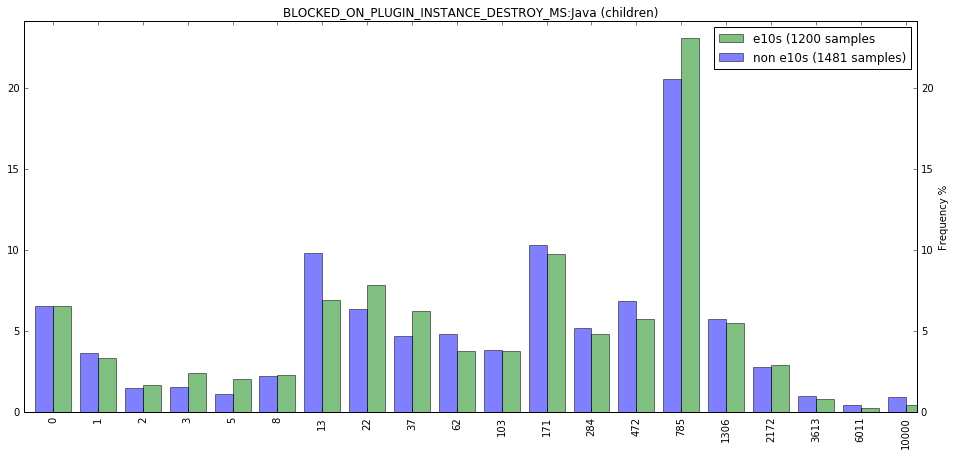

The probability that the distributions for BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS:Java (children) are differing by chance is 0.00.


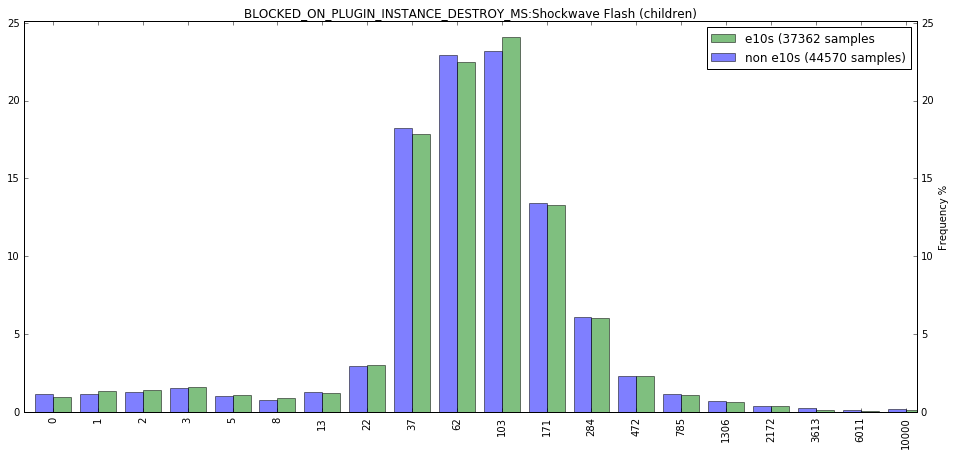

The probability that the distributions for BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS:Shockwave Flash (children) are differing by chance is 0.00.


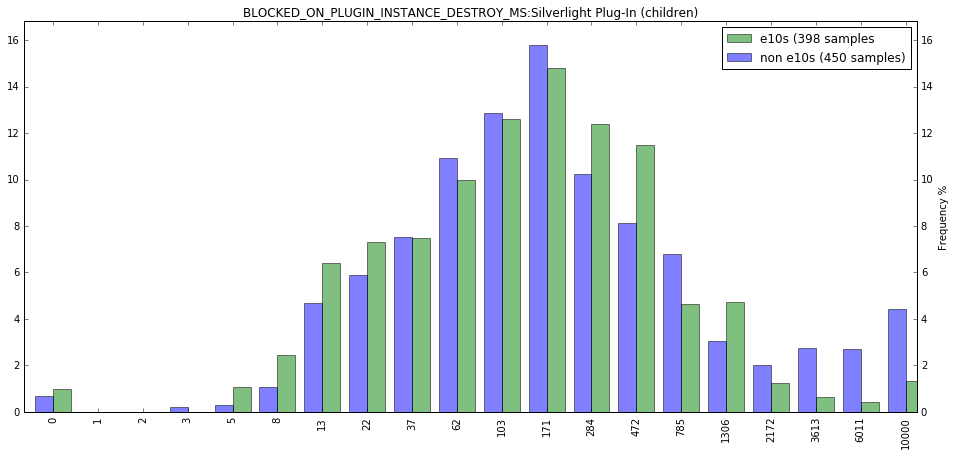

The probability that the distributions for BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS:Silverlight Plug-In (children) are differing by chance is 0.00.


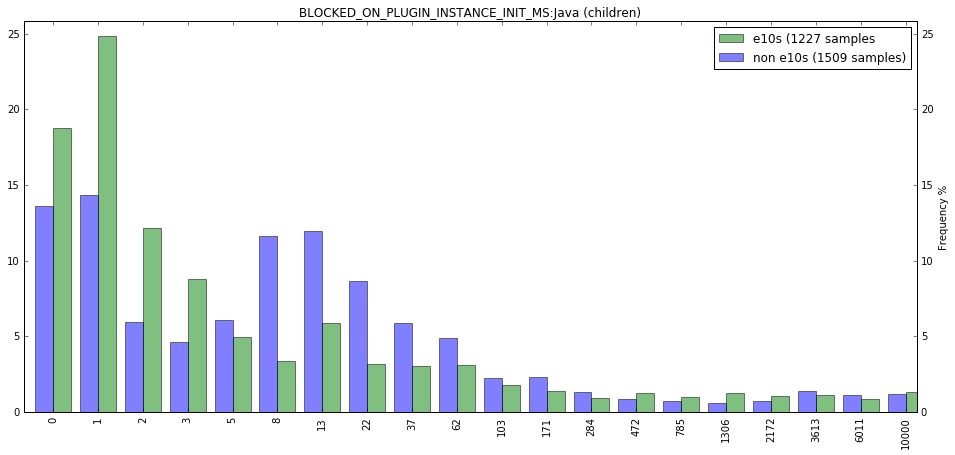

The probability that the distributions for BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS:Java (children) are differing by chance is 0.00.


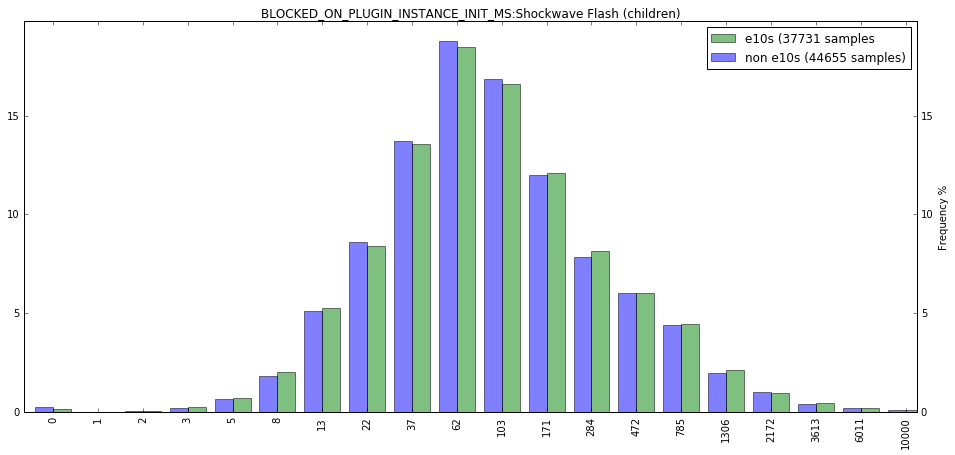

The probability that the distributions for BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS:Shockwave Flash (children) are differing by chance is 0.00.


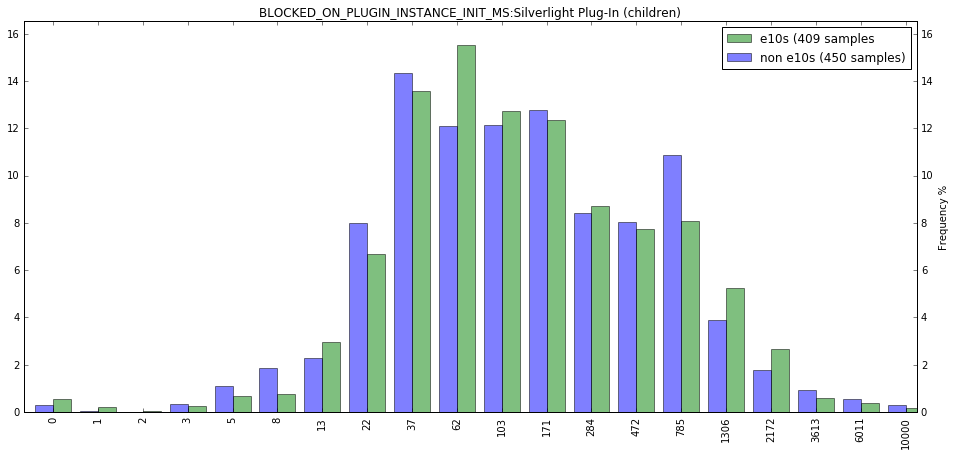

The probability that the distributions for BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS:Silverlight Plug-In (children) are differing by chance is 0.68.


In [42]:
compare_df(flash_frame)